<a href="https://colab.research.google.com/github/koreahong/computer_vision/blob/main/Object_detection_%EA%B8%B0%EB%B3%B8%EC%9D%B4%EB%A1%A0_%EB%B0%8F_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 데이터 영속성을 위한 구글 드라이브 연결



In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Object detection 기본 개념

##from
[FPN 설명](https://herbwood.tistory.com/18) 설명력 * * * *   
[FPN 설명](https://towardsdatascience.com/review-fpn-feature-pyramid-network-object-detection-262fc7482610) 설명력 * * * * / 영문  
[FPN 설명](https://yeomko.tistory.com/44) 설명력 * * *  
[FPN with RPN](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c) 설명력 * * * / 엉문  



##What?
  - 뜻: Object detection은 말그대로 이미지에서 Object를 탐지하는 것

  - 종류
      - Object Classification : 객체에 대한 클라스 분류
      - Object Localization : 1 Image / 1 Object
      - Object detection : 1 Image / n Object, bounding box로 객체 표시
      - Object Segmentation : 1 Image / N Object, pixel단위에 구분선으로 객체 표시

  - 주어진 난제
      - 데이터가 많이 없음
      - 분류와 회귀를 동시에 진행해야하는 어려움
      - 실시간 영상에서 분류를 해야하기 때문에 높은 정확도와 빠른 시간을 요구
      - 정확도와 빠른수행의 트레이드 오프

  - 구성요소(RPN 기준)
      - backbone
          - ResNet(layer-cov 쌓기)
              
      - neck
          - FPN
              - return : Anchor box, 상위,하위 레이어를 살리는 피쳐맵 생성기
      - head
          - classifcation & bbox regression
          - detection 기준
              - IOU, NMS, mAP

##How?

  - sliding window: 일정한 크기의 윈도우를 왼쪽부터 그리면서 윈도우 안에 있는 객체를 파악
      - 문제점 : 너무 많은 윈도우 활용으로 시간이 많이 걸림. 그렇다고 정확도가 높아진다는 보장도 없음
  - selective search : 객체가 있을거 같은 곳에 bounging box를 그리고 일정 임계치 이상의 윈도우에만 객체를 파악, 후에 FCNN은 이를 대체하여 사용
  - datasets
      -  mscoco, parscal VOC
  - Tools
      - yolo, OpenCV, selectivesearch
  - 지표
      - IOU(GT와 bbox의 교집합 / 합집합)
      - NMS(confidence score 제일 높은 bbox를 기준으로 IOU가 일정치보다 낮은 것들은 제거, -> GT하나당 1bbox만 남기겠다는 소리)
      - AP: 한 객체의 Precision-Recall 면적. 정밀도와 재현율이 높은 모델 선택    
      - mAP : 여러객체의 평균 AP, mean average precision

  

  







# 실습

## 데이터 불러오기 및 저장

In [3]:
!wget -O /content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/audrey01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/audrey01.jpg

--2021-09-16 06:28:25--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/audrey01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30102 (29K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/audrey01.jpg’

/content/drive/MyDr 100%[===================>]  29.40K  --.-KB/s    in 0.002s  

2021-09-16 06:28:25 (16.0 MB/s) - ‘/content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/audrey01.jpg’ saved [30102/30102]



In [ ]:
!pip install selectivesearch

In [7]:
import selectivesearch
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [11]:
img =  cv2.imread("/content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/audrey01.jpg")
#cv2는 BGR로 변환되서 읽기 때문에 RGB로 변환시켜줘야 함
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

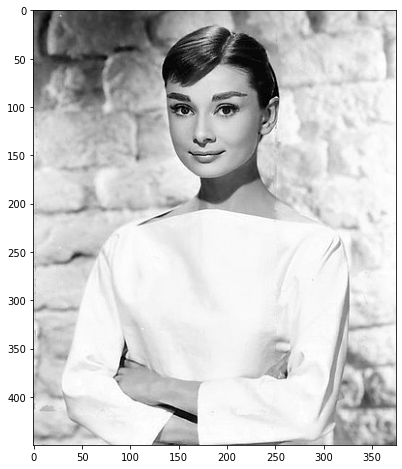

In [12]:
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor("white")
plt.imshow(img)
plt.show()

## region proposal: 객체가 있을것 같은 곳 생성

In [37]:
#selectivesearch.selective_search()는 이미지의 Region Proposal정보를 반환 
#min size: bounding box 크기
a, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))

<class 'list'> 41


- 결과해석: bbox크기가 2000이상인 객체 추정개수는 41개다

- return값: bbox별 RGB, rect정보

## bbox 그리기

- bbox size 10000 이상인 것들만

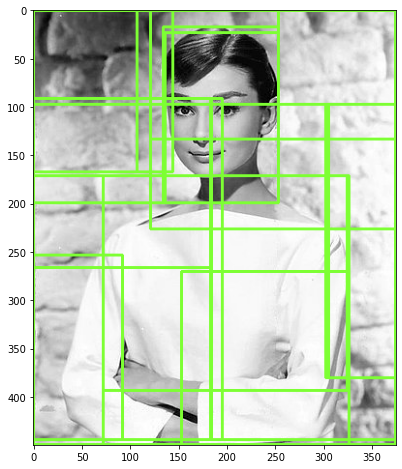

In [39]:
# bbox setting
green_rgb = (125, 255, 51)

img_rgb_copy = img_rgb.copy()
for cand in regions:
  if cand['size'] < 10000:
    continue

  rect = cand['rect']
  
  left, top = rect[0], rect[1]
  right, bottom = left + rect[2], top + rect[3]

  img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)

fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
plt.imshow(img_rgb_copy)

## IOU 구하기

In [24]:
import numpy as np

In [25]:
def compute_iou(cand_box, gt_box):

  # gt와 cand 영역 설정
  x1 = np.maximum(cand_box[0], gt_box[0])
  y1 = np.maximum(cand_box[1], gt_box[1])
  x2 = np.minimum(cand_box[2], gt_box[2])
  y2 = np.minimum(cand_box[3], gt_box[3])

  # 교집합 구간 구하기
  intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

  cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
  gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

  union = cand_box_area + gt_box_area - intersection

  iou = intersection / union

  return round(iou, 4)

In [29]:
# groud True 영역
gt_box = [60, 15, 320, 420]
red = (255, 0 , 0)

- bbox size가 5000이상, iou가 0.5를 초과하는 박스만 그리기

index : 10, iou : 0.5185,rectangle : 72, 171, 324, 393
index : 23, iou : 0.5409,rectangle : 72, 171, 326, 449
index : 33, iou : 0.549,rectangle : 0, 97, 374, 449
index : 37, iou : 0.6341,rectangle : 0, 0, 374, 444
index : 38, iou : 0.6271,rectangle : 0, 0, 374, 449
index : 39, iou : 0.6271,rectangle : 0, 0, 374, 449
index : 40, iou : 0.6271,rectangle : 0, 0, 374, 449


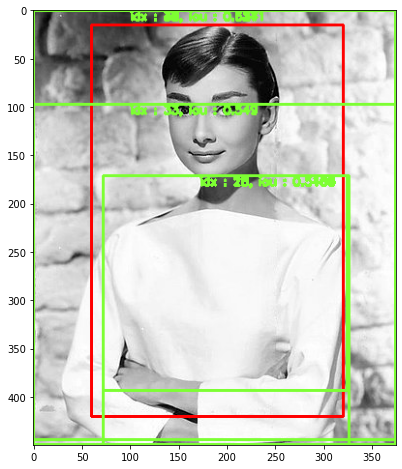

In [46]:
img_rgb_copy = img_rgb.copy()
img_rgb_copy = cv2.rectangle(img_rgb_copy, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

for idx, cand in enumerate(regions):
  
  if cand['size'] < 5000:
    continue

  rect = list(cand['rect'])
  
  rect[2] += rect[0]
  rect[3] += rect[1]

  iou = compute_iou(rect, gt_box)

  if iou > 0.5:
    print(f"index : {idx}, iou : {iou},rectangle : {rect[0]}, {rect[1]}, {rect[2]}, {rect[3]}" )
    img_rgb_copy = cv2.rectangle(img_rgb_copy, (rect[0], rect[1]), (rect[2], rect[3]), color=green_rgb, thickness=2)
    text = f"idx : {idx}, iou : {iou}"
    cv2.putText(img_rgb_copy, text, (rect[0]+ 100, rect[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=green_rgb, thickness=2)
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
plt.imshow(img_rgb_copy)

- 이렇게 이미지가 있으면 해당하는 객체를 찾는 것이다

## NMS 적용(미완)

추후 confidence가 나오는 라이브러리 사용하면 수정할 것

In [47]:
def nms(boxes, probs, threshold):
  """Non-Maximum supression.
  Args:
    boxes: array of [cx, cy, w, h] (center format)
    probs: array of probabilities
    threshold: two boxes are considered overlapping if their IOU is largher than
        this threshold
    form: 'center' or 'diagonal'
  Returns:
    keep: array of True or False.
  """
 
  order = probs.argsort()[::-1]
  keep = [True]*len(order)
 
  for i in range(len(order)-1):
    ovps = batch_iou(boxes[order[i+1:]], boxes[order[i]])
    for j, ov in enumerate(ovps):
      if ov > threshold:
        keep[order[j+i+1]] = False
  return keep

## 실시간 동영상에 적용하는 방법

### 데이터 불러오기

In [ ]:
!wget -O /content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/Night_Day_Chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/Night_Day_Chase.mp4?raw=true

In [ ]:
# 원본이미지 디렉토리
video_input_path = '/content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/Night_Day_Chase.mp4'
# bbox를 그린 수정이미지 디렉토리
video_output_path = '/content/drive/MyDrive/머신러닝_실전예제/딥러닝/data/Night_Day_Chase_out.mp4'

#fps에 따라서 frame을 따기
cap = cv2.VideoCapture(video_input_path)
#codec 설정
codec = cv2.VideoWriter_fourcc(*'XVID')
#video size 가져오기
vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) #(200, 400)
#fps 설정
vid_fps = cap.get(cv2.CAP_PROP_FPS )

# 수정이미지 객체생성
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps)

In [78]:
# 코랩 버전에서 위의 sample은 John wick이지만 실제 Video 처리는 강의와 동일하게 Night and Day로 수행. 

cap = cv2.VideoCapture(video_input_path)
# Codec은 *'XVID'로 설정. 
codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) #(200, 400)
vid_fps = cap.get(cv2.CAP_PROP_FPS )
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, 'FPS:', round(vid_fps), 'Frame 크기:', vid_size)

총 Frame 갯수: 1383 FPS: 28 Frame 크기: (1216, 516)


In [ ]:
import time

green_color=(0, 255, 0)
red_color=(0, 0, 255)

start = time.time()
index=0
while True:
    hasFrame, img_frame = cap.read()
    if not hasFrame:
        print('더 이상 처리할 frame이 없습니다.')
        break
    index += 1
    print('frame :', index, '처리 완료')
    
    """
    여기에 객체를 판별하는 알고리즘을 넣어서 실시간 비디오의 객체 판별
    """

    cv2.rectangle(img_frame, (300, 100, 800, 400), color=green_color, thickness=2)
    caption = "frame:{}".format(index)
    cv2.putText(img_frame, caption, (300, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 1)
    
    vid_writer.write(img_frame)

print('write 완료 시간:', round(time.time()-start,4))
vid_writer.release()
cap.release()   